**Начать стоит с того, что датасет очень объемный в части фич для каждого работяги. Итак, нам нужно будет сначала понять, что представляет собой каждая фича, и как она влияет на уровень зарплаты**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

###

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

C:\Users\donat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv("engineers_salary_prediction/train.csv")
test = pd.read_csv("engineers_salary_prediction/test.csv")

print(train.info())
print(train.describe())
print(train.head())
print(train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Columns: 317 entries, obs to job_desc_300
dtypes: bool(9), float64(302), int64(1), object(5)
memory usage: 3.0+ MB
None
               obs    feature_2  feature_10  job_desc_001  job_desc_002  \
count  1280.000000  1280.000000  834.000000   1280.000000   1280.000000   
mean    640.500000     0.592414   57.388489      0.195011      1.775129   
std     369.648482     0.108669   31.695205      0.223345      0.786083   
min       1.000000     0.377300    6.000000     -0.763939      0.000000   
25%     320.750000     0.470400   36.000000      0.000000      1.644593   
50%     640.500000     0.599500   60.000000      0.199483      1.965052   
75%     960.250000     0.685425   60.000000      0.362435      2.236504   
max    1280.000000     0.906300  300.000000      0.871714      3.954989   

       job_desc_003  job_desc_004  job_desc_005  job_desc_006  job_desc_007  \
count   1280.000000   1280.000000   1280.000000   1

<Data Dictionary>

- obs: Observation number of the data
- job_title: Anonymized job title
- job_posted_date: Year and month when the job was posted
- salary_category: The salary category (this is the target variable)
- job_state: State where the job is located
- feature_1 ~ feature_12: Various independent variables relating to job information
- job_desc_1 ~ job_desc_300: Vectorized representation of the job description

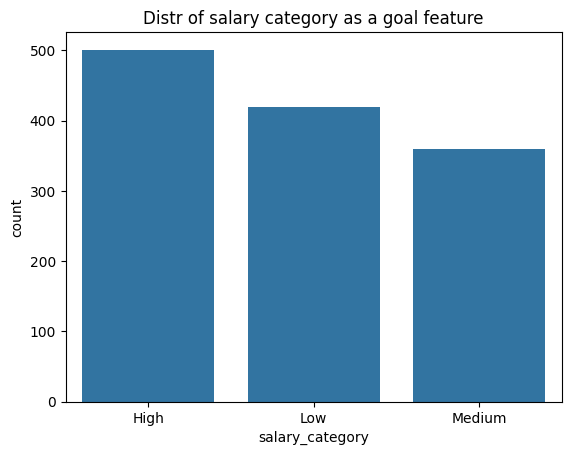

In [3]:
sns.countplot(data = train, x = 'salary_category')
plt.title("Distr of salary category as a goal feature")
plt.show()

В целом класс сбаланирован, но интересен момент, что инженеров с высоким уровнем дохода больше(хотя сначала могло казаться, что по стандартному нормальному распределению средний уровень зарплаты должен превалировать над другими).

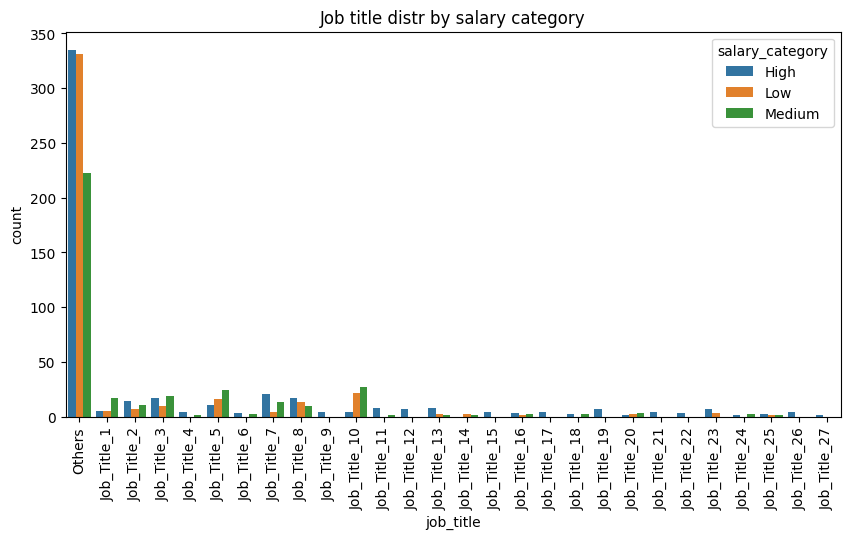

In [4]:
plt.figure(figsize = (10, 5))
sns.countplot(data = train, x = 'job_title', hue = 'salary_category')
plt.xticks(rotation = 90)
plt.title('Job title distr by salary category')
plt.show()

не понял

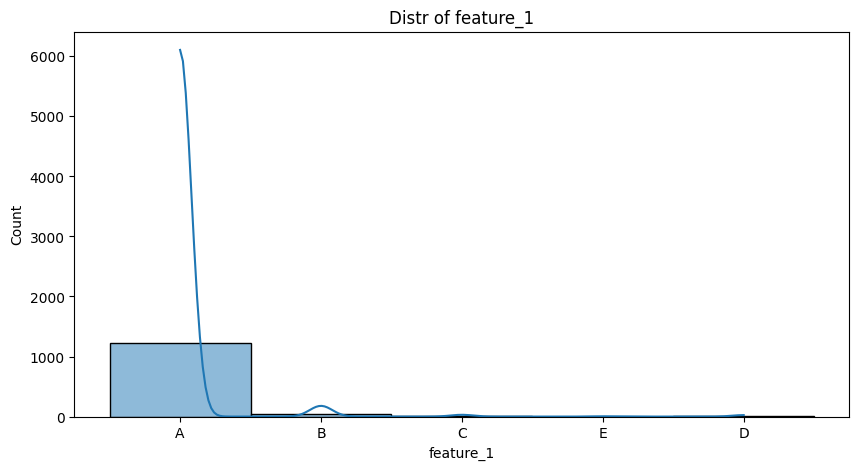

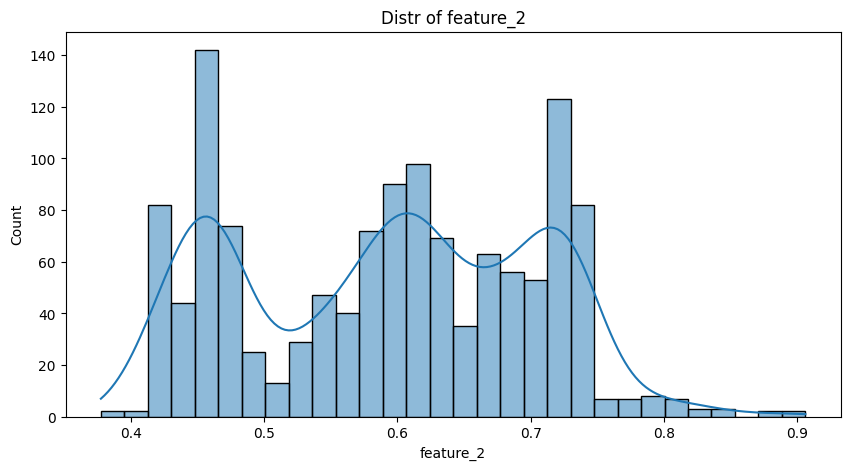

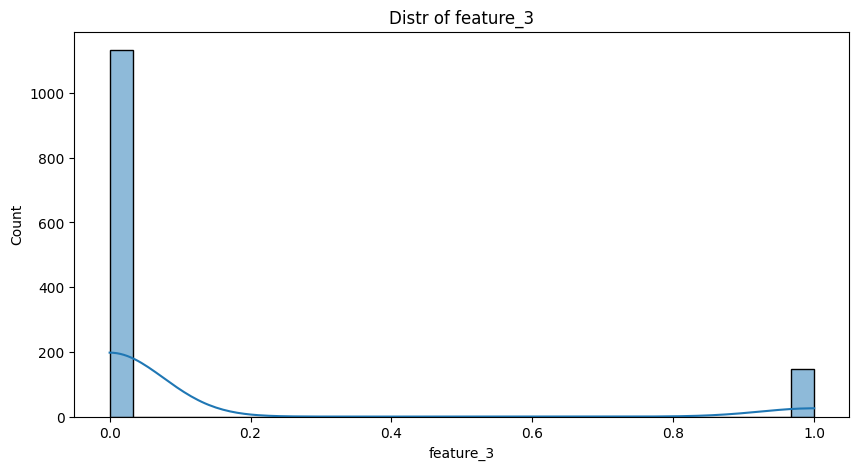

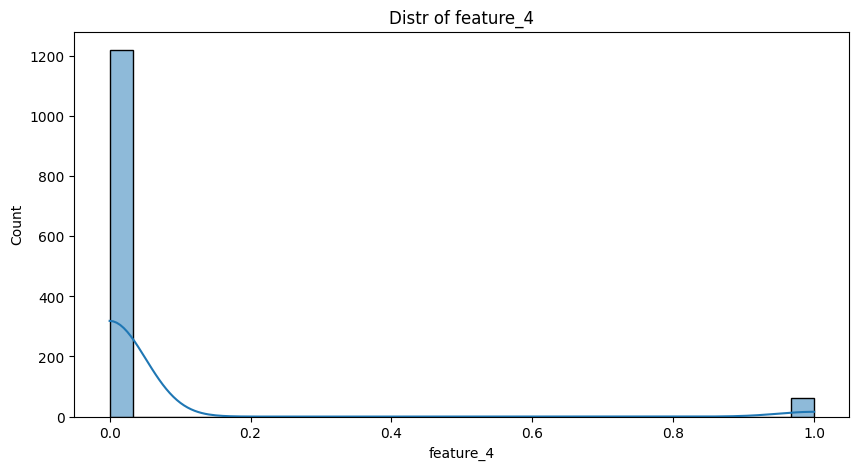

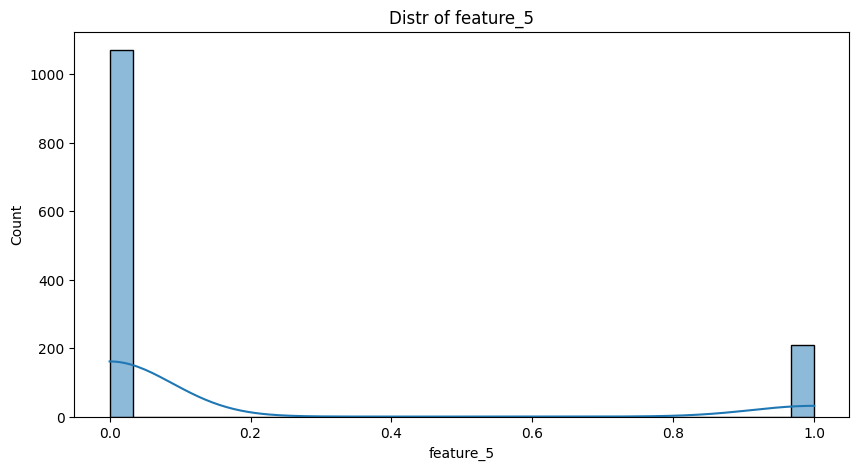

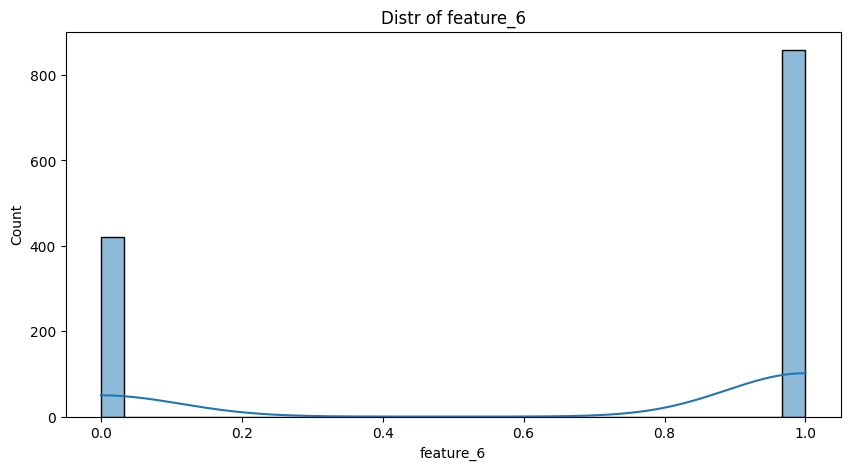

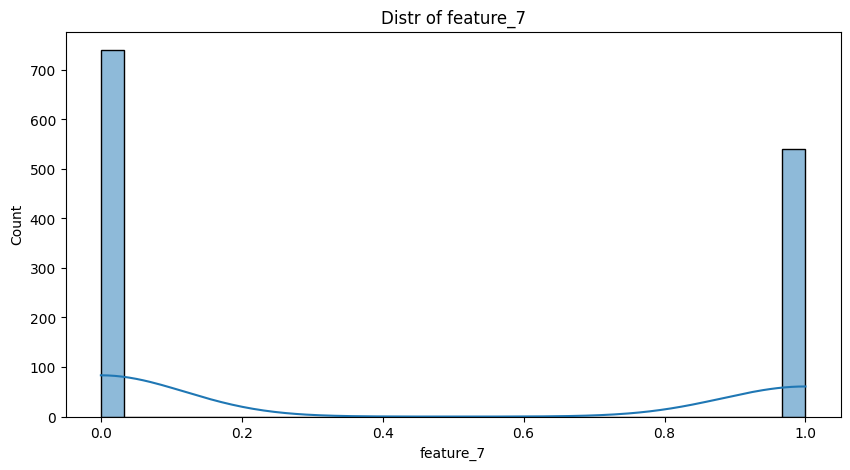

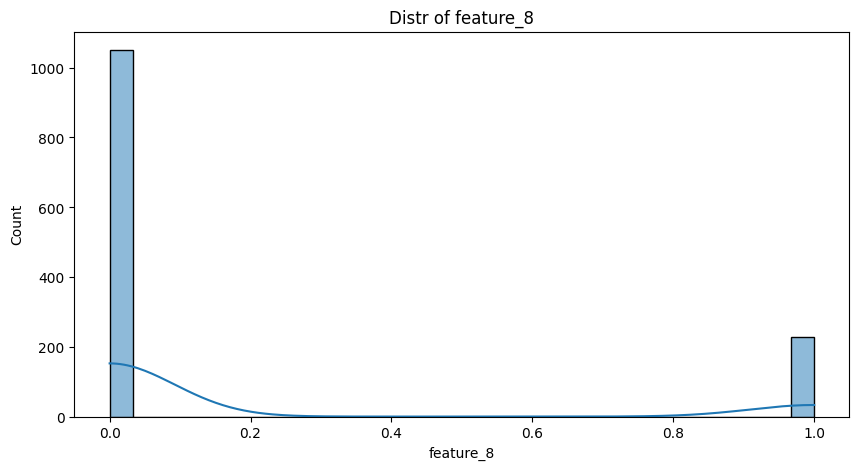

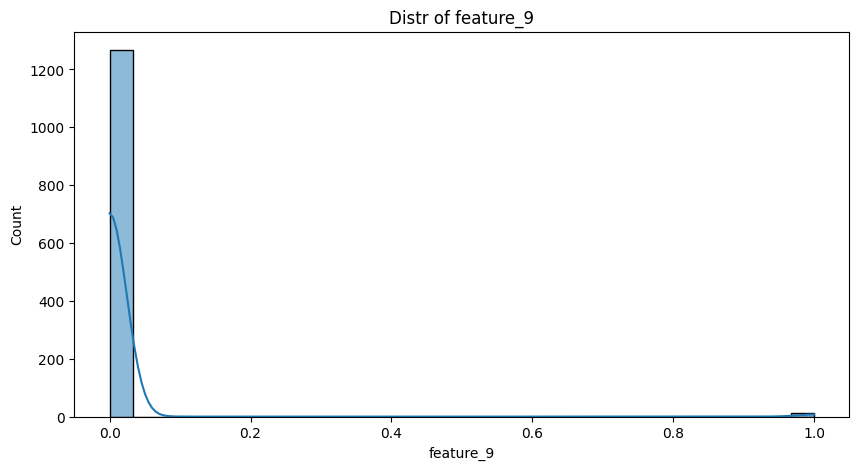

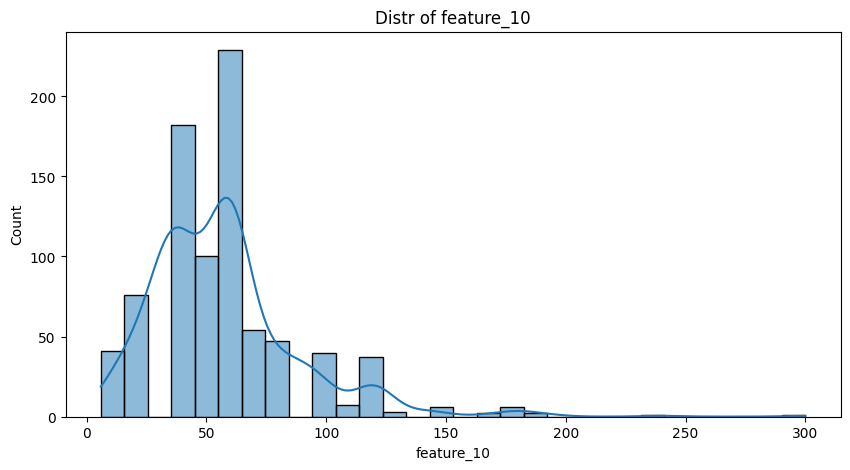

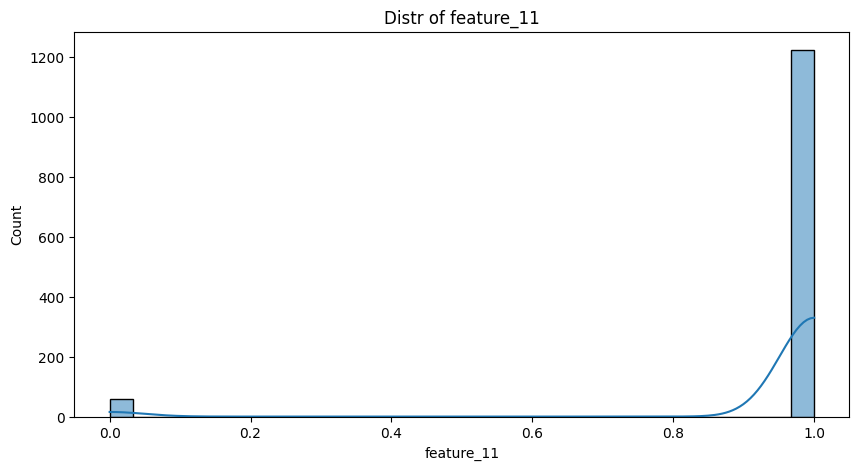

In [5]:
numeric_features = [f'feature_{i}' for i in range(1, 12)]

for feature in numeric_features:
    plt.figure(figsize = (10, 5))
    sns.histplot(train[feature], kde = True, bins = 30)
    plt.title(f'Distr of {feature}')
    plt.show()

Стандартизировать значения не имеет смысла - распределение фичей не нормальное

C:\Users\donat\AppData\Local\Temp\ipykernel_6504\105742972.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['job_posted_date'] = pd.to_datetime(train['job_posted_date'])
C:\Users\donat\AppData\Local\Temp\ipykernel_6504\105742972.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_data[col] = le.fit_transform(train[col])
C:\Users\donat\AppData\Local\Temp\ipykernel_6504\105742972.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

Non-numeric columns: Index(['feature_1', 'feature_3', 'feature_4', 'feature_5', 'feature_6',
       'feature_7', 'feature_8', 'feature_9', 'feature_11', 'feature_12'],
      dtype='object')
All features presented in the dataset
Correlation eith salary category
salary_category_encoded    1.000000
job_desc_286               0.225988
job_desc_031               0.222145
job_desc_135               0.221525
job_desc_187               0.220327
                             ...   
job_desc_084              -0.186104
feature_10                -0.192048
job_desc_108              -0.204750
job_desc_174              -0.206033
job_desc_027              -0.228533
Name: salary_category_encoded, Length: 317, dtype: float64


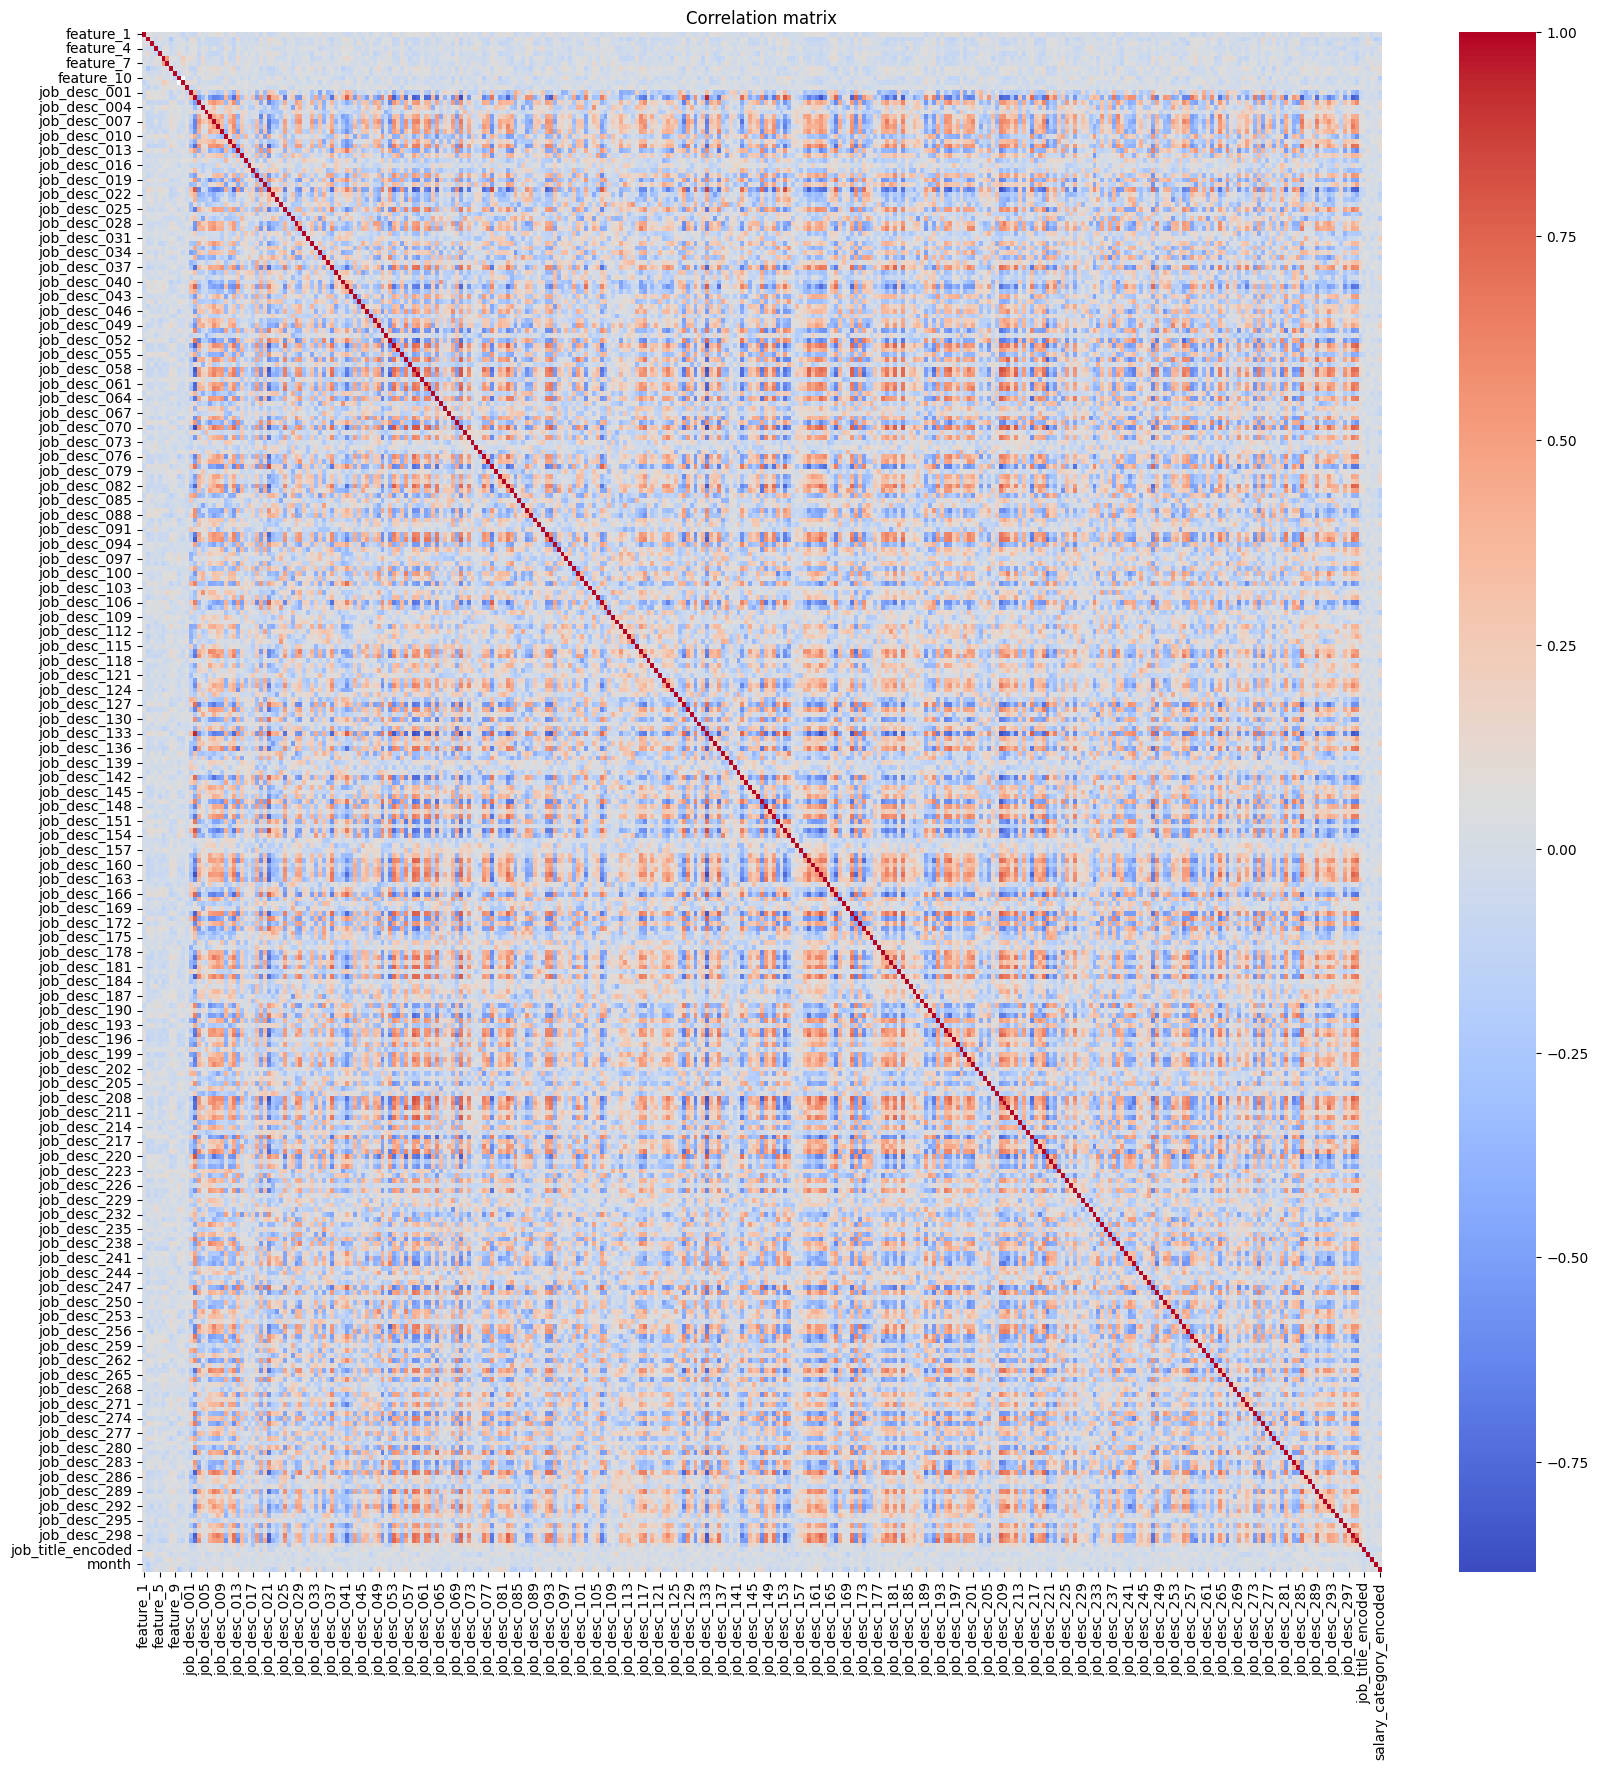

In [6]:
le = LabelEncoder()
train['salary_category_encoded'] = le.fit_transform(train['salary_category'])

train['job_title_encoded'] = le.fit_transform(train['job_title'])
train['job_state_encoded'] = le.fit_transform(train['job_state'])
train['job_posted_date'] = pd.to_datetime(train['job_posted_date'])
train['year'] = train['job_posted_date'].dt.year
train['month'] = train['job_posted_date'].dt.month

job_desc_columns = [f'job_desc_{str(i).zfill(3)}' for i in range(1, 301)]
numeric_features = [f'feature_{i}' for i in range (1, 13)] + job_desc_columns + ['job_title_encoded', 'job_state_encoded', 'year', 'month', 'salary_category_encoded']
numeric_data = train[numeric_features]

non_numeric_columns = numeric_data.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

for col in non_numeric_columns:
    le = LabelEncoder()
    numeric_data[col] = le.fit_transform(train[col])

missing_features = [col for col in numeric_features if col not in train.columns]
if missing_features:
    print(f"Missing features: {missing_features}")
else:
    print("All features presented in the dataset")

# zero_check_features = [f'job_desc_{str(i).zfill(3)}' for i in range(1, 301)]
# rows_with_zeros = (numeric_data[zero_check_features] == 0 ).all(axis = 1)
# print(f"ABCD: {rows_with_zeros.sum()}")
# train_filtered = numeric_data[~rows_with_zeros]

#print(numeric_data.dtypes)
#print(numeric_data[zero_check_features].dtypes)
# print(f"Original: {len(numeric_data)}")
# print(f"Filtered: {len(train_filtered)}")

corr_matrix = numeric_data.corr()

correlation_with_target = corr_matrix['salary_category_encoded'].sort_values(ascending = False)

print("Correlation eith salary category")
print(correlation_with_target)

plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix, annot = False, cmap = 'coolwarm', fmt = '.2f')
plt.title("Correlation matrix")
plt.show()

По тепловой карте замечаю, что фичи скоррелированы в необычном формате - карта выглядит симметричной и сегментированной на области(некая "сетка"). Скорее всего это связано с тем, что датасет и фичи в частности были сгенерированы по какому-то распределению(незвестному нам, очевидно).

**В идеях не использовать фичи, скоррелированные с salary_category более чем на |0.5|**

In [14]:
correlation_threshold = 0.5

high_corr_features = correlation_with_target[(correlation_with_target.abs() > correlation_threshold) & (correlation_with_target.index != 'salary_category_encoded')].index

print("Features with high correlation:")
print(high_corr_features)
numeric_data_filtered = numeric_data.drop(columns = high_corr_features)

# all_zero_rows = (numeric_data_filtered == 0).all(axis = 1)

# print(all_zero_rows.sum())

# numeric_data_filtered = numeric_data_filtered[~all_zero_rows]

Features with high correlation:
Index([], dtype='object')


**Таких фич не оказалось**

In [15]:
y = numeric_data_filtered['salary_category_encoded']  # Целевая переменная
X = numeric_data_filtered.drop(columns=['salary_category_encoded'])  # Признаки

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# imputer = SimpleImputer(strategy='mean')
# X_train = imputer.fit_transform(X_train)
# X_val = imputer.transform(X_val)

# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# print("Распределение классов до балансировки:")
# print(pd.Series(y_train).value_counts())

# print("Распределение классов после балансировки:")
# print(pd.Series(y_train_resampled).value_counts())

# from sklearn.decomposition import PCA

# job_desc_columns = [f'job_desc_{str(i).zfill(3)}' for i in range(1, 301)]

# pca = PCA(n_components=50) 
# X_train_pca = pca.fit_transform(X_train[job_desc_columns])
# X_val_pca = pca.transform(X_val[job_desc_columns])

In [ ]:
# indices = np.arange(X_train.shape[0])
# np.random.shuffle(indices)

# X_train_shuffled = X_train.iloc[indices] if isinstance(X_train, pd.DataFrame) else X_train[indices]
# y_train_shuffled = y_train.iloc[indices] if isinstance(y_train, pd.Series) else y_train[indices]

# train_pool = Pool(X_train_shuffled, label=y_train_shuffled)
# val_pool = Pool(X_val, label=y_val)

model = CatBoostClassifier(
    iterations=10000,
    learning_rate=0.002, # best = 0.003 and 0.005
    random_state=42,
    verbose=100,
    eval_metric='Accuracy',
    l2_leaf_reg=3,
    random_strength=2,
    #subsample=0.8,
    #colsample_bylevel=0.8,
    #bootstrap_type='Bernoulli',
    #early_stopping_rounds=50
    #ignored_features = 100
)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val)
)


y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

model.save_model('catboost_model.cbm')

0:	learn: 0.5185547	test: 0.4218750	best: 0.4218750 (0)	total: 44.6ms	remaining: 7m 26s
100:	learn: 0.6103516	test: 0.4648438	best: 0.5000000 (3)	total: 2.04s	remaining: 3m 19s
200:	learn: 0.6142578	test: 0.4687500	best: 0.5000000 (3)	total: 3.82s	remaining: 3m 6s
300:	learn: 0.6279297	test: 0.4804688	best: 0.5000000 (3)	total: 5.74s	remaining: 3m 5s
400:	learn: 0.6503906	test: 0.4921875	best: 0.5000000 (3)	total: 7.55s	remaining: 3m
500:	learn: 0.6621094	test: 0.4843750	best: 0.5039063 (441)	total: 9.28s	remaining: 2m 55s
600:	learn: 0.6718750	test: 0.4921875	best: 0.5039063 (441)	total: 11s	remaining: 2m 52s
700:	learn: 0.6835938	test: 0.5000000	best: 0.5039063 (441)	total: 12.8s	remaining: 2m 49s
800:	learn: 0.6982422	test: 0.4960938	best: 0.5039063 (441)	total: 14.6s	remaining: 2m 47s
900:	learn: 0.7109375	test: 0.5039063	best: 0.5039063 (441)	total: 16.3s	remaining: 2m 44s
1000:	learn: 0.7216797	test: 0.5117188	best: 0.5117188 (973)	total: 18s	remaining: 2m 41s
1100:	learn: 0.7333

Лучший результат == 0.8047

In [ ]:
model = XGBClassifier(n_estimators=2000, max_depth=7, scoring='accuracy', learning_rate=0.001, eval_metric='error', random_state=42)

# param_grid = {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [1000, 2000, 3000]}
# grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=3, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
model.save_model("xgboost.json")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000}

In [ ]:
model = LGBMClassifier(n_estimators = 5000, learning_rate = 0.01, random_state = 42)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_val)
#model.save_model('lightgbm_model.cbm')
print(f"Validation aacuracy: {accuracy_score(y_val, y_pred):.4f}")

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# def objective(trial):
#     n_estimators = trial.suggest_int("n_estimators", 100, 1000)
#     max_depth = trial.suggest_int("max_depth", 5, 50)
#     min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
#     bootstrap = trial.suggest_categorical("bootstrap", [True, False])

#     model = RandomForestClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         bootstrap=bootstrap,
#         random_state=42,
#         n_jobs=-1
#     )

#     model.fit(X_train_resampled, y_train_resampled)

#     y_pred = model.predict(X_val)

#     accuracy = accuracy_score(y_val, y_pred)
#     return accuracy

# study = optuna.create_study(direction="maximize")

# study.optimize(objective, n_trials=50)

# print("Best parameters:", study.best_params)
# print("Best accuracy:", study.best_value)

model = RandomForestClassifier(
        n_estimators=1000,
        max_depth=9,
        verbose=100,
        min_samples_split=3,
        min_samples_leaf=4,
        bootstrap=True,
        random_state=42,
        criterion='log_loss',
        class_weight='balanced_subsample',
        

    )
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")
joblib.dump(model, 'random_forest.joblib')

In [ ]:
model = RandomForestClassifier(n_estimators=420, max_depth = 36, min_samples_split=17, min_samples_leaf=1, bootstrap = False)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")

In [ ]:
estimators = [('xgb', XGBClassifier()), ('lgbm', LGBMClassifier())]
model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f"Validation accuracy: {accuracy_score(y_val, y_pred):.4f}")

**попытка в CNN**

In [ ]:
numeric_features = [f'feature_{i}' for i in range(1, 13)] + \
                   [f'job_desc_{str(i).zfill(3)}' for i in range(1, 301)]

for col in numeric_features:
    train[col] = pd.to_numeric(train[col], errors='coerce')
    test[col] = pd.to_numeric(test[col], errors='coerce')

train[numeric_features] = train[numeric_features].fillna(0)
test[numeric_features] = test[numeric_features].fillna(0)

X_train = train[numeric_features].values.astype(np.float32)
X_test = test[numeric_features].values.astype(np.float32)
y_train = train['salary_category_encoded'].values.astype(np.int64)

class SalaryDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_dataset = SalaryDataset(X_train_split, y_train_split)
val_dataset = SalaryDataset(X_val_split, y_val_split)
test_dataset = SalaryDataset(X_test)


train_loader = DataLoader(train_dataset, batch_size=312, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=312, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=312, shuffle=False)

class CNN1DModel(nn.Module):
    def __init__(self, input_length, num_classes):
        super(CNN1DModel, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size = 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256 * (input_length // 8), 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        #self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        #x = self.dropout(x)
        x = self.fc2(x)

        return x

input_length = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = CNN1DModel(input_length, num_classes)

# class_weights = torch.tensor([1.0, 2.0, 3.0])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay= 0.0001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=250):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
        
        train_accuracy = accuracy_score(all_labels, all_preds)

        model.eval()
        val_labels = []
        val_preds = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())
        
        val_accuracy = accuracy_score(val_labels, val_preds)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=230)

# def evaluate_model(model, test_loader, has_labels=True):
#     model.eval()
#     all_labels = []
#     all_preds = []

#     with torch.no_grad():
#         for batch in test_loader:
#             if has_labels:
#                 inputs, labels = batch
#             else:
#                 inputs = batch
#                 labels = None

#             outputs = model(inputs)

#             probs = torch.softmax(outputs, dim=1)
#             _, preds = torch.argmax(probs, 1)

#             if has_labels:
#                 all_labels.extend(labels.cpu().numpy())
#             all_preds.extend(preds.cpu().numpy())

#     if has_labels:
#         test_accuracy = accuracy_score(all_labels, all_preds)
#         print(f"Test Accuracy: {test_accuracy:.4f}")
#     else:
#         print("No labels provided for evaluation.")

# evaluate_model(model, test_loader, has_labels = False)

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for inputs in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds

test_predictions = evaluate_model(model, test_loader)

def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs in test_loader:
            outputs = model(inputs)
            pred_probab = nn.Softmax(dim=1)(outputs)
            preds = pred_probab.argmax(1)
            predictions.extend(preds.cpu().numpy())
    return predictions

predictions = predict(model, test_loader)

le = LabelEncoder()
le.fit(['Low', 'Medium', 'High'])
predicted_salary_category = le.inverse_transform(test_predictions)

predictions = np.clip(predictions, 0, len(le.classes_) - 1)

submission = pd.DataFrame({'obs': test['obs'], 'salary_category': predicted_salary_category})
submission.to_csv('submission.csv', index=False)

**слабо - качество предсказаний ниже обычных регрессионных классификаторов**

**модель попроще - многослойный перцептрон**

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class SalaryDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]


X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

train_dataset = SalaryDataset(X_train_split, y_train_split)
val_dataset = SalaryDataset(X_val_split, y_val_split)

train_loader = DataLoader(train_dataset, batch_size=312, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=312, shuffle=False)

input_size = X_train.shape[1]
hidden_size = 128
num_classes = len(np.unique(y_train))

model = MLPModel(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.00525)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.8)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.7)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.000525, weight_decay=0.5)


def evaluate_val_accuracy(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_accuracy = accuracy_score(all_labels, all_preds)
    return val_accuracy


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)

        val_accuracy = evaluate_val_accuracy(model, val_loader)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")


train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1000)

def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs in test_loader:
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim = 1)
            _, preds = torch.max(probs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

predictions = predict(model, test_loader)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(['Low', 'Medium', 'High'])
predicted_salary_category = le.inverse_transform(predictions)

submission = pd.DataFrame({'obs': test['obs'], 'salary_category': predicted_salary_category})
submission.to_csv('submission.csv', index=False)

**хуже, чем CNN**

**тест перцептрона и гиперпараметров для него**

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SalaryDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

X_train_original = X_train
y_train_original = y_train

X_train, X_val, y_train, y_val = train_test_split(
    X_train_original,
    y_train_original,
    test_size=0.2,
    random_state=42,
    stratify=y_train_original
)

input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))

train_dataset = SalaryDataset(X_train, y_train)
val_dataset = SalaryDataset(X_val, y_val)

def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 64, 256)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 312])
    num_epochs = trial.suggest_int("num_epochs", 500, 2000)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = MLPModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

...

**Пока лучшая модель - catboost**

**инференс моделек**

In [ ]:
test = pd.read_csv('D:/PAC-Competition/engineers_salary_prediction/test.csv')

le = LabelEncoder()
test['job_title_encoded'] = le.fit_transform(test['job_title'])
test['job_state_encoded'] = le.fit_transform(test['job_state'])

test['job_posted_date'] = pd.to_datetime(test['job_posted_date'])
test['year'] = test['job_posted_date'].dt.year
test['month'] = test['job_posted_date'].dt.month

job_desc_columns = [f'job_desc_{str(i).zfill(3)}' for i in range(1, 301)]
numeric_features = [f'feature_{i}' for i in range(1, 13)] + job_desc_columns + ['job_title_encoded', 'job_state_encoded', 'year', 'month']

X_test = test[numeric_features]

for col in X_test.columns:
    if X_test[col].dtype == 'object':
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

from_file = CatBoostClassifier()
from_file.load_model("catboost_model.cbm")

# model_feature_names = from_file.get_feature_names()
# test_feature_names = X_test.columns.tolist()

# if test_feature_names == model_feature_names:
#     print("Feature names match!")
# else:
#     print("Feature names mismatch")
#     print("Missing features in X_test:", set(model_feature_names) - set(test_feature_names))
#     print("Extra features in X_test:", set(test_feature_names) - set(model_feature_names))

#     X_test = X_test.reindex(columns=model_feature_names, fill_value=0)

predictions = from_file.predict(X_test)

label_encoder = LabelEncoder()
label_encoder.fit(['Low', 'Medium', 'High'])
predicted_labels = label_encoder.inverse_transform(predictions)

submission = pd.DataFrame({'obs': test['obs'], 'salary_category': predicted_labels})
submission.to_csv('submission.csv', index=False)

In [ ]:
test = pd.read_csv('D:/PAC-Competition/engineers_salary_prediction/test.csv')

le = LabelEncoder()
test['job_title_encoded'] = le.fit_transform(test['job_title'])
test['job_state_encoded'] = le.fit_transform(test['job_state'])

test['job_posted_date'] = pd.to_datetime(test['job_posted_date'])
test['year'] = test['job_posted_date'].dt.year
test['month'] = test['job_posted_date'].dt.month

job_desc_columns = [f'job_desc_{str(i).zfill(3)}' for i in range(1, 301)]
numeric_features = [f'feature_{i}' for i in range(1, 13)] + job_desc_columns + ['job_title_encoded', 'job_state_encoded', 'year', 'month']

X_test = test[numeric_features]

for col in X_test.columns:
    if X_test[col].dtype == 'object':
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

model = joblib.load('random_forest.joblib')

predictions = model.predict(X_test)

label_encoder = LabelEncoder()
label_encoder.fit(['Low', 'Medium', 'High'])
predicted_labels = label_encoder.inverse_transform(predictions)

submission = pd.DataFrame({'obs': test['obs'], 'salary_category': predicted_labels})
submission.to_csv('submission.csv', index=False)